# **Mitigating Bias in clustering**

This notebook is a tutorial on auditing bias within a clustering task. We will use the _holisticai_ library throughout, introducing some of the functions we have created to help study algorithmic bias.

The sections are organised as follows :

1. Load the data : we load the adult dataset as a pandas DataFrame
2. Data Exploration : some preliminary analysis of the data
3. Pre-Processing and Train a Model : we train a kmeans model (sklearn)
4. Measure Bias : we compute a few bias metrics, and comment on their meaning

## **Load the data**

In [1]:
# Imports
import numpy as np
import pandas as pd

#sys
import sys
sys.path.append('../../')

We will start by importing the adult dataset, which we host on our library. The adult dataset contains a set of informations extract from US 1994 Census database. It includes personal information about the individuals, specifically sex, race, and education. In this tutorial we will perform unsupervised learning to cluster the data, then measure whether this clustering contains gender or race information (clustering bias).

In [2]:
# Get data
from holisticai.datasets import load_adult
df = load_adult()['frame']
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


## **Data Exploration**

In [3]:
# import holisticai charts
from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import histogram_plot

<AxesSubplot:>

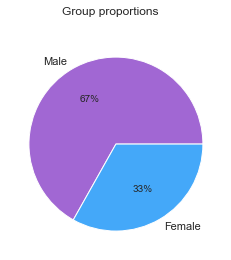

In [4]:
# pie plot of the Sex column
p_attr = df['sex']
group_pie_plot(p_attr)

<AxesSubplot:>

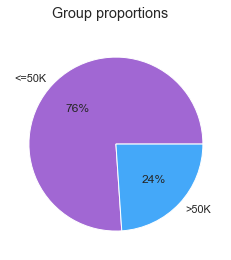

In [5]:
# pie plot of class column
p_attr = df['class']
group_pie_plot(p_attr)

<AxesSubplot:xlabel='race', ylabel='Probability'>

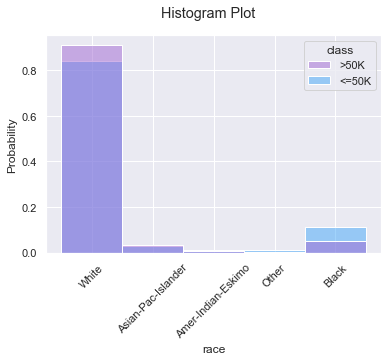

In [6]:
# Histogram of race with class as hue
histogram_plot(df['race'], df['class'])

## **Preprocess data and Train a model**

In [7]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [8]:
# Dataset
dataset = load_adult()

# Dataframe
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
protected_variables = ["sex", "race"]
output_variable = ["class"]

# Simple preprocessing
y = df[output_variable].replace({">50K": 1, "<=50K": 0})
X = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1))
group = ["sex"]
group_a = df[group] == "Female"
group_b = df[group] == "Male"
data = [X, y, group_a, group_b]

# Train test split
dataset = train_test_split(*data, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]

In [9]:
from sklearn.cluster import KMeans

ks = range(1, 8)
inertias = []
X_train, _, group_a_train, group_b_train = train_data

for k in ks:
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # fit model to samples
    model.fit(X_train)
    
    # append the inertia to the list of inertias
    inertias.append(model.inertia_)

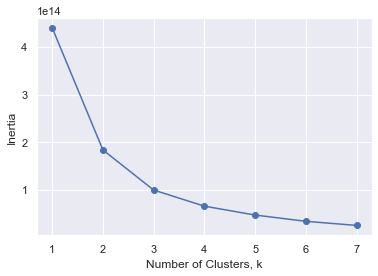

In [10]:
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [11]:
# we choose to use 4 clusters
model = KMeans(n_clusters = 4)
model.fit(X_train)

# test data
X, _, group_a, group_b = test_data

# predict
y_pred = model.predict(X)

## **Measure bias**

In [12]:
# imports
from holisticai.bias.plots import frequency_matrix_plot
from holisticai.bias.metrics import cluster_balance
from holisticai.bias.metrics import min_cluster_ratio

In [13]:
# set up vectors for measuring bias [we consider sex and race]
p_attr_sex = df.iloc[X.index]['sex']
p_attr_race = df.iloc[X.index]['race']
y_pred = model.predict(X)

<AxesSubplot:xlabel='Class', ylabel='Group'>

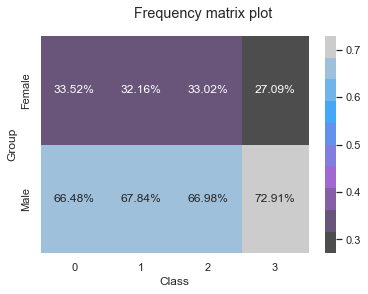

In [14]:
# probability for each gender and class
frequency_matrix_plot(p_attr_sex, y_pred, normalize='class')

The clustering is quite balanced in terms of gender representations.

<AxesSubplot:xlabel='Class', ylabel='Group'>

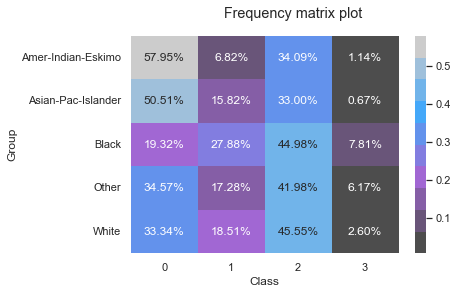

In [15]:
# probability for each race and group
frequency_matrix_plot(p_attr_race, y_pred, normalize='group')

In terms of race representations, some clusters are quite unbalanced. So the kmeans model has learnt some implicit Race information. Depending on the application of interest, this might be a bias issue.

In [16]:
group_a = p_attr_race=='Amer-Indian-Eskimo'
group_b = p_attr_race=='White'
cluster_balance(group_a, group_b, y_pred)

0.3546688934069126

The above metric indicates the clustering is not balanced in the sense of each group having similar representation in clusters to overall. The ideal value for this metric would be 1.

In [17]:
group_a = p_attr_race=='Amer-Indian-Eskimo'
group_b = p_attr_race=='White'
min_cluster_ratio(group_a, group_b, y_pred)

0.003878474466709761

The above metric indicates there is a cluster where there are about 253 times more white people than Amer-Indian-Eskimos. This makes sense because of the difference in representation in overall population.

### Batch computation

In [18]:
# import batch computer
from holisticai.bias.metrics import clustering_bias_metrics

In [19]:
# set up data arrays 
group_a = p_attr_sex=='Female'
group_b = p_attr_sex=='Male'
y_pred = y_pred
centroids = model.cluster_centers_
data = X.to_numpy()

In [20]:
clustering_bias_metrics(group_a, group_b, y_pred, data = data, centroids = centroids, metric_type = 'equal_outcome')

,Value,Reference
Metric,,
Cluster Balance,0.824954,1
Minimum Cluster Ratio,0.371560,1
Cluster Distribution Total Variation,0.013876,0
Cluster Distribution KL Div,0.001308,0
Social Fairness Ratio,0.978531,1
Silhouette Difference,0.002301,0


In [21]:
from holisticai.bias.mitigation import VariationalFairClustering
from holisticai.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('bm_inprocessing', VariationalFairClustering(n_clusters=4, lmbda=4000, method='kmeans', verbose=True))])
pipeline.fit(X_train, bm__group_a = group_a_train, bm__group_b = group_b_train)

c:\Users\Cristian\anaconda3\envs\metrics\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pipeline(steps=[('scaler', StandardScaler()),
                ('bm_inprocessing',
                 <holisticai.pipeline.handlers._estimator.WEstimator object at 0x000002D10A142B20>)])

In [22]:
p_attr_sex = df.iloc[X.index]['sex']
p_attr_race = df.iloc[X.index]['race']
group_a = p_attr_sex=='Female'
group_b = p_attr_sex=='Male'
y_pred2 = pipeline.predict(X, bm__group_a=group_a, bm__group_b=group_b)
centroids2 = pipeline['bm_inprocessing'].cluster_centers_

<AxesSubplot:xlabel='Class', ylabel='Group'>

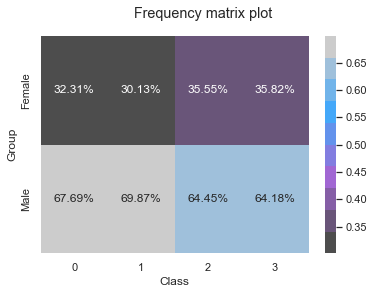

In [23]:
# probability for each race and group
frequency_matrix_plot(p_attr_sex, y_pred2, normalize='class')

In [24]:
clustering_bias_metrics(group_a, group_b, y_pred2, data = data, centroids = centroids2, metric_type = 'both')

,Value,Reference
Metric,,
Cluster Balance,0.916838,1
Minimum Cluster Ratio,0.431234,1
Cluster Distribution Total Variation,0.053076,0
Cluster Distribution KL Div,0.006492,0
Social Fairness Ratio,0.975447,1
Silhouette Difference,-0.001259,0


The above metrics hint that the computed clustering **not** biased in terms of sex attribute.